In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.utils.np_utils import to_categorical
from keras import datasets, layers, models
from keras.applications import ResNet50
from keras.models import Model

# 1: Acquire the Data

In [ ]:
#load the data, vectorize it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

unormalized_x_train = x_train
unormalized_x_test = x_test

# normalization to [0,1] range
x_train = x_train / 255.0
x_test = x_test /255.0

## reshape the inputs
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

#reshaping unormalized images
unormalized_x_train = unormalized_x_train.reshape(unormalized_x_train.shape[0],-1)
unormalized_x_test = unormalized_x_test.reshape(unormalized_x_test.shape[0],-1)
y_train_uncat=y_train
y_train = to_categorical(y_train)

#flatten
y_train_uncat = y_train_uncat.flatten()
y_test = y_test.flatten()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(32, 32, 3), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))


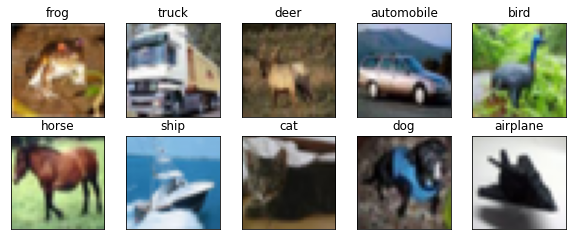

In [ ]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
list_ = []
y = 0

#Show unique training images
for i in range(36):
    label_index = int(y_train_uncat[i])
    if class_names[label_index] not in list_:
      plt.subplot(5, 5, y + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x_train[i].reshape((32, 32, 3)))
      plt.title(class_names[label_index])
      list_.append(class_names[label_index])
      y += 1
plt.show()

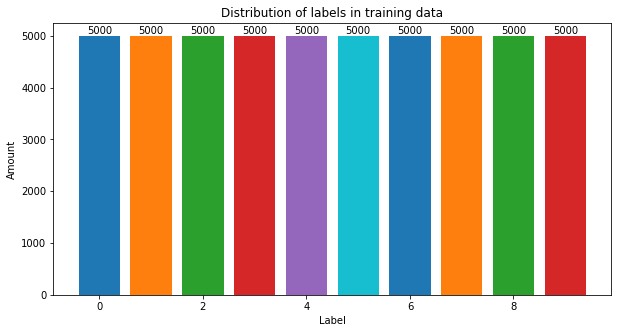

In [ ]:

#Distribution of training data class
targets, frequency = np.unique(y_train_uncat, return_counts=True)

fig=plt.figure(figsize=(10, 5))
plt.bar(targets,frequency,color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:cyan'])
plt.title('Distribution of labels in training data')
plt.xlabel('Label')
plt.ylabel('Amount')

for a,b in zip(targets, frequency):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

plt.show()
     

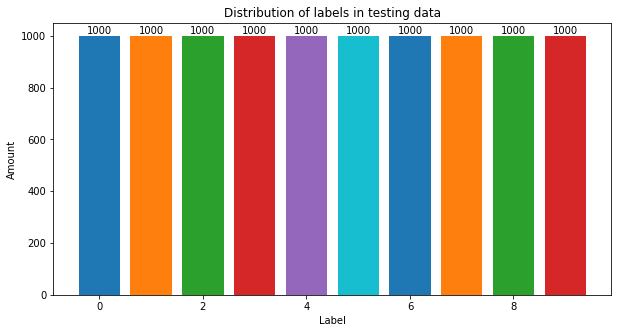

In [ ]:
#Distribution of training data class
targets, frequency = np.unique(y_test, return_counts=True)

fig=plt.figure(figsize=(10, 5))
plt.bar(targets,frequency,color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:cyan'])
plt.title('Distribution of labels in testing data')
plt.xlabel('Label')
plt.ylabel('Amount')

for a,b in zip(targets, frequency):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)
    
plt.show()
     

# 2. Implement a Multilayer Percoptron

In [ ]:
class Cost_Cross_Entropy:
    def __init__(self, activation_fn):
        self.activation_fn = activation_fn
        self.gamma=None

    def transform(self, x, gamma=0.01):
      self.gamma=gamma
      return self.activation_fn.transform(x,gamma=gamma)

    def loss(y_true, y_pred):
        epsilon=1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        loss = -np.sum(y_true*np.log(y_pred+1e-9))/N
        return loss

    @staticmethod
    def derivative(Y, AL):  
        return AL - Y

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred, self.gamma)

In [ ]:
class MLP:

    def __init__(self, input_layer=3072, hidden_layer=[], output_layer=10, epochs=20, active_func=[], batch_size=200, learning_rate=0.1, gamma=0.01, l1reg = 0, l2reg = 0):
        self.gamma=gamma
        self.epochs=epochs
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        self.l1reg = l1reg
        self.l2reg = l2reg

        self.dimensions=[input_layer]
        for h in hidden_layer:
          self.dimensions.append(h)
        self.dimensions.append(output_layer)

        self.num_layers = len(self.dimensions)
        self.weights = {}
        self.bias = {}
        self.active_func = {}
        rng=len(self.dimensions) - 1

        #put small random weights for each layer and divide it by the square root of input size (calibrating variance)
        for i in range(rng):
            self.weights[i + 1] = np.random.randn(self.dimensions[i], self.dimensions[i + 1])
            dim_sqrt = np.sqrt(self.dimensions[i])
            self.weights[i + 1]= self.weights[i + 1]/dim_sqrt
        # 0 bias everywhere
        for i in range(rng):
            self.bias[i + 1] = np.zeros(self.dimensions[i + 1])

        count=0
        rng=len(active_func)
        if (rng==0):
          self.active_func[2]=Softmax
        else:
          for i in range(rng):
              count=i+2
              self.active_func[i + 2] = active_func[i]
          self.active_func[count+1]=Softmax
        self.loss = Cost_Cross_Entropy(self.active_func[self.num_layers])


    def propagate(self, x):
        y_x = {}
        y_c = {1: x}  
        for idx in range(1, self.num_layers):
            next_idx=idx+1
            y_x[next_idx] = self.bias[idx] + np.dot(y_c[idx], self.weights[idx])
            y_c[next_idx] = self.active_func[next_idx].transform(y_x[next_idx], self.gamma)
        return y_x, y_c  

    def back_propagate(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.num_layers])
        dw = np.dot(a[self.num_layers - 1].T, delta)

        params = {
            self.num_layers - 1: (dw, delta)
        }

        for i in reversed(range(2, self.num_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.active_func[i].derivative(z[i], self.gamma)
            dw = np.dot(a[i - 1].T, delta)
            params[i - 1] = (dw, delta)
	
        for key, val in params.items():
            dw=val[0]
            index=key

            #l1 reg
            dw += self.l1reg * np.sign(-1 * self.weights[index])

            #l2 reg
            dw += self.l2reg * self.weights[index]

            self.weights[index] -= self.learning_rate * dw
            self.bias[index] -= self.learning_rate * np.mean(val[1], 0)
    
    def fit(self, X_train, y_train):


        for i in range(self.epochs):
            #randomly select the group
            seed = np.arange(X_train.shape[0])
            np.random.shuffle(seed)
            x_ = X_train[seed]
            y_ = y_train[seed]
            iter = X_train.shape[0] // self.batch_size

            for i2 in range(iter):
                k = i2 * self.batch_size
                l = (i2 + 1) * self.batch_size
                y_x, y_c = self.propagate(x_[k:l])
                self.back_propagate(y_x, y_c, y_[k:l])

            if (i + 1) % 10 == 0:
               _, a = self.propagate(X_train)
               y_pred = a[self.num_layers]
              
    def predict(self, x):
        y_x, y_c = self.propagate(x)
        return np.argmax(y_c[self.num_layers],axis=1)

    @staticmethod   
    def evaluate (true_,predicted):
        predicted_shape=predicted.shape[0]
        return np.sum(true_ == predicted)/predicted_shape







In [ ]:

class Relu:
    def transform(x,gamma=0.01):
      return np.maximum(0,x)
    def derivative(d, gamma=0.01):
        mask = d <= 0
        out=d.copy()
        out[mask] = 0
        out[d>0] = 1
        return out

class Leaky_Relu:
    def transform(x, gamma=0.01):
      return np.maximum(0,x) + gamma*np.minimum(0,x)

    def derivative(d, gamma=0.01):
        mask = d <= 0
        out=d.copy()
        out[mask] = gamma
        out[d>0] = 1
        return out

class Sigmoid:
    def transform(x,gamma=0.01):
        return 1 / (1 + np.exp(-x))
    def derivative(d, gamma=0.01):
        d_transformed = 1 / (1 + np.exp(-d))
        return d_transformed * (1 - d_transformed)

class Tanh:
    def transform(x,gamma=0.01):
      return np.tanh(x)
      
    def derivative(d, gamma=0.01):
      transformed = Tanh.transform(d,gamma=0.01)
      return 1 - transformed**2


class Softmax:
    def transform(x,gamma=0.01):
      exp_ = x-np.max(x)
      nx = np.exp(exp_)
      sum = np.sum(nx, axis=1, keepdims=True)
      return nx/sum

    def derivative(d,gamma=0.01):
        return Softmax.transform(d,gamma=0.01)*Softmax.transform(1-d,gamma=0.01)

# 3. Run the Experiments and Report

In [ ]:

### function for graphing
def graphing(hidden, activ, gamma_val=0.01, l1regg=0, l2regg=0, batch_val = 20, learning_val=0.1, epochs = [0,1,2,4,8,16,32,64,100,200]):
  epoch_options = epochs
  training_accuracies = []
  testing_accuracies = []
  for epoch in epoch_options:
    model = MLP(hidden_layer=hidden, active_func=activ,gamma=gamma_val,l1reg=l1regg, l2reg=l2regg,epochs=epoch,
                batch_size=batch_val, learning_rate=learning_val)
    model.fit(x_train,y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    training_accuracy = model.evaluate(y_train_uncat, y_predict_train)
    testing_accuracy = model.evaluate(y_test, y_predict_test)
    print("epoch: " + str(epoch) + ' test accuracy: '+ str(testing_accuracy) + ' training accuracy: '+ str(training_accuracy))
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    
  plt.plot(epoch_options,training_accuracies,label='training accuracies')
  plt.plot(epoch_options,testing_accuracies,label='testing accuracies')
  plt.xlabel('epochs')
  plt.ylabel('accuracies')
  plt.legend()
  plt.show()


### 3.1. create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs to outputs, (2) an MLP with a single hidden layer having 256 units and ReLU activations, (3) an MLP with 2 hidden layers each having 256 units with ReLU activations. It should be noted that since we want to perform classification, all of these models should have a softmax layer at the end. After training, compare the test accuracy of these three models on the CIFAR-10 dataset. Comment on how non-linearity and network depth affects the accuracy. Are the results that you obtain expected?


In [ ]:
hidden_layer_options = [[],[256],[256,256]]
for hidden_layer_amount in hidden_layer_options:
  activ=[]
  for j in range(len(hidden_layer_amount)):
    activ.append(Relu)
  graphing(hidden=hidden_layer_amount,activ=activ)

### 3.2. Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with model having ReLU activations. Comment on the performances of these models: which one is better and why? Are certain activations better than others? If the results are not as you expected, what could be the reason?

In [ ]:
graphing(hidden=[256,256],activ=[Tanh,Tanh])


In [ ]:
graphing(hidden=[256,256],activ=[Leaky_Relu,Leaky_Relu])


### 3.3. Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time, independently add L1 and L2 regularization to the network and train the MLP in this way. How do these regularizations affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be explored as part of other project requirements.

**L2 regularization**

In [ ]:

lambdas_ = [0.001,0.01,0.1,1,10]
for lambda_ in lambdas_:
  print("With lambda: " + str(lambda_))
  graphing(hidden=[256,256], activ=[Relu, Relu], l2regg=lambda_)
     

**L1 regularization**

In [ ]:
lambdas_ = [0,0.001,0.01,0.1,1,10]
for lambda_ in lambdas_:
  graphing(hidden=[256,256], activ=[Relu, Relu], l1regg=lambda_)

Testing for different gamma values

In [ ]:

gamma_values=[0.001, 0.01, 0.1, 0.25, 0.5, 1.0]
for gm in gamma_values:
  graphing(hidden=[256],activ=[Leaky_Relu],gamma_val=gm)

### 3.4. Create an MLP with 2 hidden layers each having 256 units with ReLUctivations as above. However, this time, train it with unnormalized images. How does this affect the accuracy?


In [ ]:

model =  MLP(hidden_layer=[256,256], active_func=[Relu, Relu], epochs=32)
model.fit(unormalized_x_train,y_train)
y_predict = model.predict(unormalized_x_test )
print(  "accuracy: " + str(model.evaluate(y_test, y_predict))  )

Testing for different batch sizes and learning rates

In [ ]:

batch_sizes = [5, 50, 100,200,400]
for size in batch_sizes:
  graphing(hidden=[256,256],activ=[Relu, Relu], batch_val=size, epochs=[32])

epoch: 32 test accuracy: 0.501 training accuracy: 0.66144


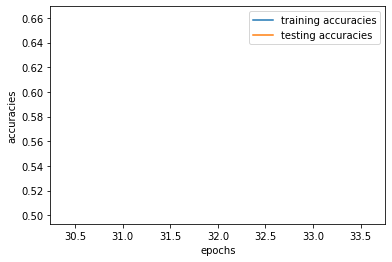

epoch: 32 test accuracy: 0.515 training accuracy: 0.69672


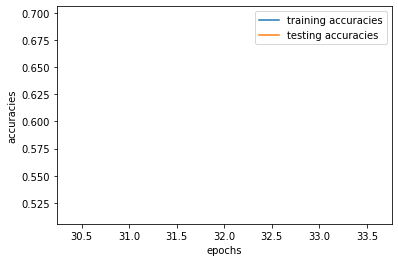

epoch: 32 test accuracy: 0.5179 training accuracy: 0.66678


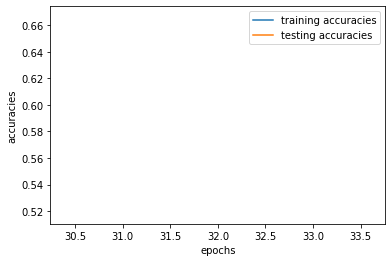

epoch: 32 test accuracy: 0.5087 training accuracy: 0.56962


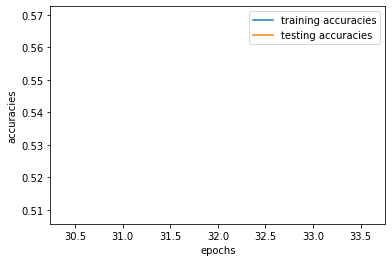

epoch: 32 test accuracy: 0.489 training accuracy: 0.51848


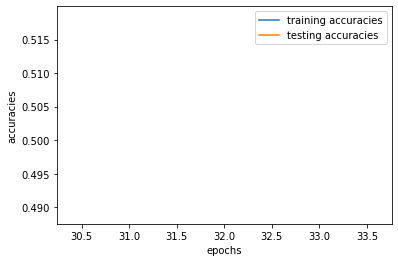

In [ ]:

rates = [0.2, 0.1, 0.05, 0.01, 0.005, 0.001]
for rate in rates:
  graphing(hidden=[256,256],activ=[Relu, Relu], learning_val=rate, epochs=[32])

### 5.Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2 convolutional and 2 fully connected layers. Although you are free in your choice of the hyperparameters of the convolutional layers, set the number of units in the fully connected layers to be 256. Also, set the activations in all of the layers to be ReLU. Train this CNN on the CIFAR-10 dataset. Does using a CNN increase/decrease the accuracy compared to using MLPs? Provide comments on your results.

In [ ]:
(x_train2, y_train2), (x_test2, y_test2) = tf.keras.datasets.cifar10.load_data()

# normalization to [0,1] range
x_train2 = x_train2 / 255.0
x_test2 = x_test2 /255.0

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(10))
model.summary()


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train2, y_train2, epochs=8, 
                    validation_data=(x_test2, y_test2))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
test_loss, test_acc = model.evaluate(x_test2,  y_test2, verbose=2)

In [ ]:
print(test_acc)

###6. Load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch, and then freeze all the convolutional layers and remove all the fully connected ones. Add a number of fully connected layers of your choice right after the convolutional layers. Train only the fully connected layers of the pre-trained model on the CIFAR-10 dataset. How does this pre-trained model compare to the best MLP in part 1 and to the regular CNN in part 5 in terms of the accuracy? How does it compare to the previous models in terms of the required training time? Justify your choice of how many fully connected layers that you have added to the pre-trained model through careful experiments.

In [ ]:
resnet50_imagenet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
flattened = tf.keras.layers.Flatten()(resnet50_imagenet_model.output)
fc1 = tf.keras.layers.Dense(256, activation='relu', name="AddedFC1")(flattened)
fc2 = tf.keras.layers.Dense(256, activation='softmax', name="AddedFC2")(fc1)
fc3 = tf.keras.layers.Dense(10, activation='softmax', name="AddedFC3")(fc2)

model = tf.keras.models.Model(inputs=resnet50_imagenet_model.input, outputs=fc3)
a = 0
for i in model.layers:
    a += 1
    if(a < 177):
        i.trainable = False
    else:
        i.trainable = True
#model.summary()


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train2, y_train2, epochs=10, 
                    validation_data=(x_test2, y_test2))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(x_test2,  y_test2, verbose=2)
print(test_acc)


